In [3]:
%matplotlib inline
from pathlib import Path
import pickle
from PIL import Image
import io
import gdown
import zipfile

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import argparse

# define seed
manualSeed = 999
print(f"Seed: {manualSeed}")
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Seed: 999


### Load Data

**The Potato Image Dataset (TPID):** </br>
* The included dataset is comprised of red (600) ,red washed (604), white (600) , and sweet potatoes (600). </br>
* It contains 2,404 images in total. </br>


This set has been manually derived from the following dataset: </br>
https://www.kaggle.com/datasets/moltean/fruits?select=fruits-360_dataset

In [4]:
# training imgs download url + output file name definition
url = 'https://drive.google.com/uc?id=1A423Vi62SWb3FHtwieXDlmtIEcQHb2ub'
outfile = "imgs.zip"

# download imgs if imgs folder does not exist
if not os.path.exists("imgs"):
    gdown.download(url, outfile, quiet=False)

    with zipfile.ZipFile(outfile, 'r') as zip_ref:
        zip_ref.extractall()
    os.remove("imgs.zip")

### Globals

*From the DCGAN paper (Alec Radford & Luke Metz)*

"No pre-processing will be applied to training images besides scaling to the range of the Tanh activation function `[-1, 1]`. 
All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of `128`. 
All weights were initialized from a zero-centered Normal distribution with standard deviation `0.02`. 
In the `LeakyReLU`, the slope of the leak was set to `0.2` in all models.
While previous GAN work has used momentum to accelerate training, we used the Adam optimizer with tuned hyperparameters. 
We found the suggested learning rate of `0.001`, to be too high, using `0.0002` instead. 
Additionally, we found leaving the momentum term `β1` at the suggested value of `0.9` resulted in training oscillation and instability while reducing it to `0.5` helped stabilize training."

**NOTE:** Scaling each channel of the input image is defined as: `channel_values = (channel_values - mean) / std` </br>
in other words the range for our input data would be `((0-0.5)/0.5) = -1` to `((1-0.5)/0.5) = 1`

In [5]:
cwd = os.getcwd() # collect current working directory
dataroot = Path(f"{cwd}/imgs") # define data directory
workers = 2 # number of workers for dataloader
batch_size = 128 # batch size during training (64 + 64)
num_channels = 3 # number of channels in the training images. For color images this is 3 (RGB)
image_size = 64 # also the size of feature maps for the generator and discriminator
z_size = 100 # size of z latent vector (i.e. size of generator input)
num_epochs = 100 # number of training epochs
# num_epochs = 400 # number of training epochs
lr = 0.0002 # learning rate for optimizers
num_gpu = 2 # number of GPUs available. Use 0 for CPU mode.

### Define Transforms, Loaders, and preview Data

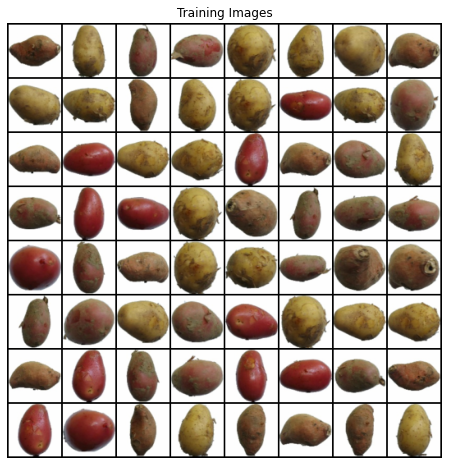

In [6]:
# define transform
tfs = transforms.Compose([transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # range per channel = [-1,1]

# define the dataset
dataset = dset.ImageFolder(root=dataroot,transform=tfs)

# define the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# define available device
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

# plot training image grid
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Build the GAN

### Weight Initialization

The authors specify that all model weights should be randomly initialized from a Normal distribution with `mean=0, stdev=0.02`. The weights_init function provided by PyTorch takes an initialized model as input and reinitialize all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function should be applied to the models immediately after initialization.

In [7]:
# custom weights initialization for netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

The Generator starts with a noise vector z. Using a fully connected layer, we reshape the vector into a three-dimensional hidden layer with a small base (width × height) and large depth. Using transposed convolutions, the input is progressively reshaped such that its base grows while its depth decreases until we reach the final layer with the shape of the image we are seeking to synthesize, 64 × 64 × 3.

Notice, how the inputs we set in the input section (z_size, image_size, and num_channels) influence the generator architecture in code. z_size is the length of the z input vector, image_size relates to the size of the feature maps that are propagated through the generator, and num_channels is the number of channels in the output image (set to 3 for RGB images).

The class implementation will be a sequential network with transpose convolutions (upsampling) also known as a fractionally-strided convolution;
in PyTorch this module is called ConvTranspose2d and can be seen as the gradient of Conv2d where we are traditionally downsampling.

Between each layer we will place a batch normalization function, calculating the mean and standard-deviation per-dimension over mini-batches. We do not use these normalized values directly. Instead, we multiply them by γ (gamma) and add β (beta) before passing them as inputs. This type of normalization is used for accelerating the training in deep networks by reducing internal covariate shift, thus stabilizing the training process. This normalization is a critical contribution of the DCGAN paper. After passing our batch through the normalization process we send it through a ReLU function, this will be the expression of our neurons within the hidden layer;

Finally the output of the generator is fed through a Tanh function to return it to the input data range of `[-1,1]`.

### ReLu

The advantage of using Leaky ReLU and replacing the 0 suppression of negetive values is that we avoid zero gradients. This is because we avoid “dead” neurons that become stuck at zero and thus are no longer contributing to training. The slope of the negative mask can be set by the parameter _alpha_, which is multiplied by the input _x_.

**Function** </br>
ReLu(x) = max(0, x) </br>
Properties = Properties = non-linear unbounded, negative value suppression, helps overcome vanishing gradient, expressive neurons </br>
Range =  [0,inf]

**Function** </br>
if x < 0 ==> alpha * x
if x >= 0 ==> x

**Gradient** </br>
if x < 0 ==> alpha
if x >= 0 ==> 1

### Tanh

As with the sigmoid function, neurons saturate at large negative and positive values, and the derivative of the function approaches zero. However, unlike the sigmoid function, its outputs are zero-centered. This function is chosen to match the input data range of our images which has been normalized to be `[-1,1]`

**Function** </br>
Tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x)) </br>
Properties = asymptotic, probabilistic, 0 centered </br>
Range =  [-1,1]

**The Quotient Rule** </br>
(a/b)' = (a'b - ab') / b^2

**Gradient** </br>
((e^x - e^(-x)) / (e^x + e^(-x)))' = 1 - (Tanh(x))^2

**Implementation** </br>
1 - (Tanh(x))^2 = 1 - Tanh(x) * Tanh(x)

In [8]:
class Generator(nn.Module):
    def __init__(self, num_gpu):
        super(Generator, self).__init__()

        self.num_gpu = num_gpu
        self.trainImgs = []
        self.losses = []
        
        tconv1 = image_size * 8 # 64 x 8 = 512 channels
        tconv2 = image_size * 4 # 64 x 4 = 256 channels
        tconv3 = image_size * 2 # 64 x 2 = 128 channels
        
        self.main = nn.Sequential(
            # input Z = 100 x 1 
            nn.ConvTranspose2d(in_channels = z_size, # 100
                               out_channels = tconv1, # 64 x 8 = 512 channels
                               kernel_size = 4, 
                               stride = 1, 
                               padding = 0, 
                               bias=False),
            nn.BatchNorm2d(tconv1),
            nn.ReLU(True),
            # feature_size = 64 / 2^4 = 64 / 16 = 4 ==> 4 x 4
            # feature_channels = 512 x 2 = 1024
            # transpose_state = 4 x 4 (1024 channels)

            nn.ConvTranspose2d(in_channels = tconv1, # 64 x 8 = 512 channels
                               out_channels = tconv2, # 64 x 4 = 256 channels
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(tconv2),
            nn.ReLU(True),
            # feature_size = 64 / 2^3 = 64 / 8 = 8 ==> 8 x 8
            # feature_channels = 256 x 2 = 512
            # transpose_state = 8 x 8 (512 channels)

            nn.ConvTranspose2d(in_channels = tconv2, # 64 x 4 = 256 channels
                               out_channels = tconv3, # 64 x 2 = 128 channels
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(tconv3),
            nn.ReLU(True),
            # feature_size = 64 / 2^2 = 64 / 4 = 16 ==> 16 x 16
            # feature_channels = 128 x 2 = 256
            # transpose_state = 16 x 16 (256 channels)

            nn.ConvTranspose2d(in_channels = tconv3, # 64 x 2 = 128 channels
                               out_channels = image_size, # 64 x 64 = 3 channels
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(True),
            # feature_size = 64 / 2^1 = 64 / 2 = 32 ==> 32 x 32
            # feature_channels = 64 x 2 = 128
            # transpose_state = 32 x 32 (128 channels)

            nn.ConvTranspose2d(in_channels = image_size,
                               out_channels = num_channels, 
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1, 
                               bias=False),
            nn.Tanh()
            # output = 64 x 64 (3 channels)
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# init generator
netG = Generator(num_gpu).to(device)

# handle multi-gpu if needed
if (device.type == 'cuda') and (num_gpu > 1):
    netG = nn.DataParallel(netG, [0])

# randomly initialize all weights to mean=0, stdev=0.2
netG.apply(weights_init)

# display model structure
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

### Discriminator

For the Discriminator class we will implement a CNN network to train against our Generator.

Between each layer we will place a LeakyReLu function for expressing our neurons, utilizing dropout of `0.2`; proper dropout essentially simulates training large numbers of architectures simultaneously. Importantly, dropout can drastically reduce the chance of overfitting during training. Finally, we use Sigmoid to output for our criterion. Note the lack of pooling seen in a typical CNN.

*From "Unsupervised representation learning With DCGANs" (Alec Radford & Luke Metz):*

"Core to our approach is adopting and modifying three recently demonstrated changes to CNN architectures.

The first is the all convolutional net (Springenberg et al., 2014) which replaces deterministic spatial
pooling functions (such as maxpooling) with strided convolutions, allowing the network to learn
its own spatial downsampling. We use this approach in our generator, allowing it to learn its own
spatial upsampling, and discriminator."

### LeakyReLu

The advantage of using Leaky ReLU and replacing the 0 suppression of negetive values is that we avoid zero gradients. This is because we avoid “dead” neurons that become stuck at zero and thus are no longer contributing to training. The slope of the negative mask can be set by the parameter _alpha_, which is multiplied by the input _x_. 

This fits the use case for our Discrimitor, since it is learning from our training set and incrimentaly informing the Generator network which weights it should have to transpose our noise into a random sample within the training data distribution.

**Function** </br>
LeakyReLu(x) = max(alpha * x, x) </br>
Properties = non-linear, unbounded, negative alpha mask, more expressive neurons </br>
Range =  [-inf,inf]

**Function** </br>
if x < 0 ==> alpha * x
if x >= 0 ==> x

**Gradient** </br>
if x < 0 ==> alpha
if x >= 0 ==> 1

### Sigmoid

The derivative of the sigmoid function becomes very small at the head and tail (i.e., large negative or positive input values). In this case, the derivative near zero would make the gradient of the loss function very small, preventing the updating of the weights and thus the entire learning process. 

An optimal gradient descent step requires the ability to increase in and a decrease in weights simultaneously. Since outputs through the Sigmoid function are always positive, we cannot increase and decrease the weights simultaneously; we can only increase or decrease all the weights simultaneously. This can make for unstable training scenarios, however in our case we are going to be adding label smoothing to assist during training thus, a range of `[0,1]` will work for this use case.

**Function** </br>
Sigmoid(x) = e^x / (1 + e^x) </br>
Properties = asymptotic, bounded, prone to vanishing gradients </br>
Range =  [0,1]

**The Quotient Rule** </br>
(a/b)' = (a'b - ab') / b^2

**Gradient** </br>
(e^x / (1 + e^x))' = S(x) * 1 / (1 + e^x)

**since** </br>
1 / (1 + e^x) = 1 - S(x)

**we have** </br>
(e^x / (1 + e^x))' = S(x) * (1 - S(x))

In [10]:
class Discriminator(nn.Module):
    def __init__(self, num_gpu):
        super(Discriminator, self).__init__()

        self.num_gpu = num_gpu
        self.losses = []

        conv1 = image_size * 2 # 64 x 2 = 128 channels
        conv2 = image_size * 4 # 64 x 4 = 256 channels
        conv3 = image_size * 8 # 64 x 8 = 512 channels

        self.main = nn.Sequential(
            # input = 64 x 64 (3 channels)
            nn.Conv2d(in_channels = num_channels, # 3
                      out_channels = image_size, # 64
                      kernel_size = 4,
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # feature_size = 64 / 2^1 = 64 / 2 = 32 ==> 32 x 32
            # feature_channels = 64 x 2 = 128
            # conv_state = 32 x 32 (128 channels)

            nn.Conv2d(in_channels = image_size, # 64
                      out_channels = conv1, # 64 x 2 = 128 channels
                      kernel_size = 4,
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.BatchNorm2d(conv1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # feature_size = 64 / 2^2 = 64 / 4 = 16 ==> 16 x 16
            # feature_channels = 128 x 2 = 256
            # conv_state = 16 x 16 (256 channels)

            nn.Conv2d(in_channels = conv1, # 64 x 2 = 128 channels
                      out_channels = conv2, # 64 x 4 = 256 channels
                      kernel_size = 4, 
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.BatchNorm2d(conv2),
            nn.LeakyReLU(0.2, inplace=True),
            # feature_size = 64 / 2^3 = 64 / 8 = 8 ==> 8 x 8
            # feature_channels = 256 x 2 = 512
            # transpose_state = 8 x 8 (512 channels)

            nn.Conv2d(in_channels = conv2, # 64 x 4 = 256 channels
                      out_channels = conv3, # 64 x 8 = 512 channels
                      kernel_size = 4,
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.BatchNorm2d(conv3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # feature_size = 64 / 2^4 = 64 / 16 = 4 ==> 4 x 4
            # feature_channels = 512 x 2 = 1024
            # transpose_state = 4 x 4 (1024 channels)

            nn.Conv2d(in_channels = conv3, # 64 x 8 = 512 channels
                      out_channels = 1,
                      kernel_size = 4,
                      stride = 1,
                      padding = 0,
                      bias=False),
            nn.Sigmoid()
            # output = 100 x 1
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# init discriminator
netD = Discriminator(num_gpu).to(device)

# handle multi-gpu if needed
if (device.type == 'cuda') and (num_gpu > 1):
    netD = nn.DataParallel(netD, [0])

# randomly initialize all weights to mean=0, stdev=0.2
netD.apply(weights_init)

# display model structure
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Dropout2d(p=0.2, inplace=False)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
      (12): Dropout2d(p=0.2, inpla

In [12]:
class Results():
    '''define object for network results storage'''
    def __init__(self):
        self.trainImgs = []
        self.gLosses = []
        self.dLosses = []

### Training

Given the function: `Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))]`</br>
Where the generator tries to minimize the function and the discriminator tries to maximize it. </br>
**NOTE:** the formula derives from the cross-entropy between the real and generated distributions. </br>

GAN Training Function: </br>
`D(x)` is the discriminator's estimate of the probability that real data instance x is real. </br>
`Ex` is the expected value over all real data instances. </br>
`G(z)` is the generator's output when given noise z. </br>
`D(G(z))` is the discriminator's estimate of the probability that a fake instance is real. </br>
`Ez` is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances `G(z))`. </br>

*From "Unsupervised representation learning With DCGANs" (Alec Radford & Luke Metz):*

"In practice, `log(D(x)) + log(1 - D(G(z)))` may not provide sufficient gradient for `G` to learn well. 
Early in learning, when `G` is poor, `D` can reject samples with high confidence because they are clearly different from the training data.
In this case, `log(1 − D(G(z)))` saturates. Rather than training `G` to minimize `log(1 − D(G(z)))` we can train `G` to maximize `log D(G(z))`.
This objective function results in the same fixed point of the dynamics of `G` and `D` but provides much stronger gradients early in learning."

"The proposed training framework corresponds to a two-player minimax game `minG maxD V(D,G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))]`. 
In the space of arbitrary functions `G` and `D`, a unique solution exists, with `G` recovering the training data distribution and `D` equal to `1/2` everywhere. 
In the case where `G` and `D` are defined by multilayer perceptrons, the entire system can be trained with backpropagation."

"Optimizing `D` to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. 
Instead, we alternate between `k` steps of optimizing `D` and one step of optimizing `G`. 
This results in `D` being maintained near its optimal solution, so long as G changes slowly enough. 
This strategy is analogous to the way that Stochastic Maximum Likelihood versus Persistent Contrastive Divergence training maintains samples from a Markov chain from one learning step to the next in order to avoid burning in a Markov chain as part of the inner loop of learning."

We select Binary Cross Entropy for our criterion since we need to determine the image is `real(1)` or `fake(0)` </br>
**NOTE:** in PyTorch BCELoss is equivalent to NLLLoss (Negative Log Likelihood) except that NLLLoss implicitly defines a Softmax function for its input.

It is common to use the class label `1` to represent real images and class label `0` to represent fake images when training the discriminator model. These are called hard labels.
Soft labels can help prevent overfitting for binary classifications, these values are slightly more or less than `1.0` or slightly more than `0.0` for real and fake images respectively, where the variation for each image is random. This is often referred to as two-sided label smoothing and can have a `regularizing` effect when training the model. For our implementation we will use one-sided label smoothing as two sided smoothing presents issues with the Generator producing erroneous samples.

*From "Improved Techniques for Training GANs" (Tim Salimans & Ian Goodfellow)*

"Label smoothing, a technique from the 1980s recently independently re-discovered by Szegedy et.
al, replaces the 0 and 1 targets for a classifier with smoothed values, like `.9` or `.1`, and was recently shown to reduce the vulnerability of neural networks to adversarial examples. Replacing positive classification targets with `α` and negative targets with `β`, the optimal discriminator `data(x) + β pmodel (x)` becomes `D(x) = αppdata(x) + pmodel(x)`. The presence of `pmodel` in the numerator is problematic because, in areas where `pdata` is approximately zero and `pmodel` is large, erroneous samples from `pmodel` have no incentive to move nearer to the data. We therefore smooth only the positive labels to `α`, leaving negative labels set to 0.

Training order of operations is as follows:
* Train Discriminator by attempting to maximize `log(D(x)) + log(1 - D(G(z)))`
    * train on real batch
    * train on fake batch
* Update Generator by attempting to maximize `log(D(G(z)))`

In [13]:
def trainGAN():
    random.seed(123)

    # init criterion
    criterion = nn.BCELoss()

    # create batch of latent vectors that we will use to visualize
    # the progression of the generator
    fixed_noise = torch.randn(image_size, z_size, 1, 1, device=device)

    # implement label smoothing
    real_label = 1.-0.3+random.random()*0.5 # 0.7~1.2 (i.e close to 1)
    fake_label = random.random()*0.3 # (i.e close to 0 but not less than)

    # define optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

    # init results object
    results = Results()
    iters = 0

    print("Starting Training Loop...")
    # for each epoch
    for epoch in range(num_epochs):
        # for each batch in the dataloader
        for i, data in enumerate(dataloader,0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # calculate loss on all-real batch
            errD_real = criterion(output, label)
            # calculate gradients for D in backward pass
            errD_real.backward() # Sigmoid gradient
            D_x = output.mean().item()

            ## Train with all-fake batch
            # generate batch of latent vectors
            noise = torch.randn(b_size, z_size, 1, 1, device=device)
            # generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward() # Sigmoid gradient
            D_G_z1 = output.mean().item()
            # compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            optimizerD.step() # update D

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label) # fake labels are real for generator cost
            # since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # calculate G's loss based on this output
            errG = criterion(output, label)
            # calculate gradients for G
            errG.backward() # Tanh gradient
            D_G_z2 = output.mean().item() 
            optimizerG.step() # update G

            # output training stats
            if i % 50 == 0:
                # [0/100][0/24]	Loss_D: 1.0707	Loss_G: 6.3156	D(x): 0.7842	D(G(z)): 0.2768 / 0.0004
                print(f'[{epoch:d}/{num_epochs:d}][{i:d}/{len(dataloader):d}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

            # store losses in results object
            results.gLosses.append(errG.item())
            results.dLosses.append(errD.item())

            # save generated (fake) output for visualization
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu() # generate fake images
                results.trainImgs.append(vutils.make_grid(fake, padding=2, normalize=True)) # add images to results object

            iters += 1
    return results

In [14]:
# define model and result paths
model_dir = Path('models')
g_path = os.path.join(model_dir,'potato_g.pkl')
d_path = os.path.join(model_dir,'potato_d.pkl')
r_path = os.path.join(model_dir,'results.pkl')

# train if either G or D is missing
if not os.path.exists(g_path) or not os.path.exists(d_path):
    results = trainGAN()

In [15]:
# save pickle file for both models and result objects, if file does not exist
if not os.path.exists(g_path):
    g_file = open(g_path, 'wb')
    pickle.dump(netG, g_file)
    g_file.close()

if not os.path.exists(d_path):
    g_file = open(d_path, 'wb')
    pickle.dump(netG, g_file)
    g_file.close()

if not os.path.exists(r_path):
    r_file = open(r_path, 'wb')
    pickle.dump(results, r_file)
    r_file.close()

# delete pickle files and re-run notebook to save new model and result objects

In [16]:
# define class to unpickle on current device (CPU or GPU), independent of which device the model was trained on.
class DeviceUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

In [17]:
# load pickle file for each model
g_file = open(g_path, 'rb')
newNetG = DeviceUnpickler(g_file).load()
g_file.close()

d_file = open(d_path, 'rb')
newNetD = DeviceUnpickler(d_file).load()
d_file.close()

r_file = open(r_path, 'rb')
newResults = pickle.Unpickler(r_file).load()
r_file.close()

# send both models to CPU if no GPU is available
if not torch.cuda.is_available():
    newNetG = newNetG.module.to(device)
    newNetD = newNetD.module.to(device)

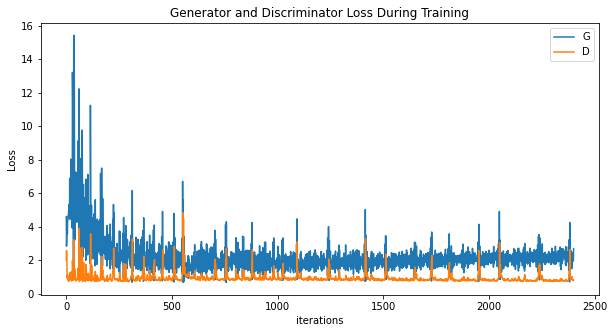

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(newResults.gLosses,label="G")
plt.plot(newResults.dLosses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

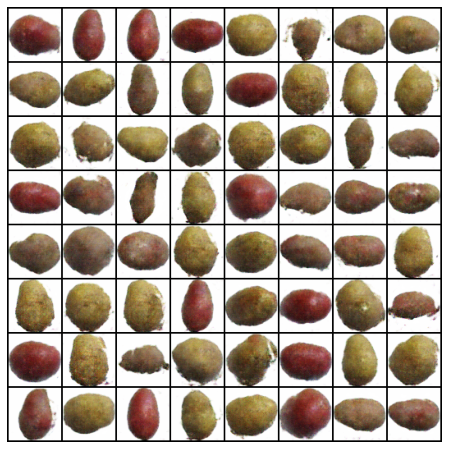

In [19]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in newResults.trainImgs[0:10]]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [20]:
def random_tater(model):
    '''generate 64 random fake images with given model then select the 0th item'''
    noise = torch.randn(64, 100, 1, 1, device=device)
    fakes = model(noise).detach().cpu()
    fake_img = fakes[0]
    grid = vutils.make_grid(fake_img, padding=2, normalize=True)
    return transforms.ToPILImage()(grid)

In [21]:
tater = random_tater(newNetG)
tater.show()

## Model Evaluation & Conclusion

### Criteria

**Qualitative criteria for a successful generator, i.e. it should generate images with:** </br>
* good quality: high fidelity and “realistic” </br>
* diversity (or variety): a good representation of the training images’ different categories </br>

**Quantitative methods for determining closeness in distribution:** </br>
* Inception Score (IS) </br>
* Fréchet Inception Distance (FID) </br>

### Qualitative Evaluation

**Image quality:** </br>
* While the final generated images begin to resemble our training images some anomalies on the edges of our generated potatoes are still present </br>
* The internal coloring appears to reflect in the generated samples well but carries over some checkerboarding patterns from the network architecture </br>

**Diversity:** </br>
Generated sample variety appears to represent our training set very well </br>

### Quantitative Evaluation
* For the sake of time and simplicity I choose to not implement either IS or FID scores for quantitative evaluation. Part of the reason for this includes the simplicity of the dataset and which was purposefully picked to match the explanatory goal of the project. I encourage the curious to explore quantitative evaluation methods of your choosing with included pre-trained generative models!
